# IMDB Rating Prediction - Random Forest

In this notebook, we predict the **rating** value using IMDB movie data
with Random Forest. Features:

- Numerical: `votes`, `runtime`
- Categorical: `genre` (multi-hot encoding), `director` (target encoding), `stars` (multi-value target encoding)
- Text: `description` (TF-IDF)

Model:
- `RandomForestRegressor`

Evaluation:
- Primary metric: **RMSE**
- Secondary metrics: **MAE**, **R²**
- Evaluation method:
  - **5-fold cross validation** on the training set (with GridSearchCV)
  - Final performance on a separate **test set** (RMSE, MAE, R²)

## 1. Loading & Cleaning Dataset

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

In [48]:
#Configuration Constants
MIN_VOTES = 100   #exclude movies with fewer votes
MIN_RUNTIME = 60     #exclude short films (less than 1 hour)
SMOOTH_FACTOR = 10    #smoothing factor for target encoding (prevents overfitting)

In [49]:
data_path = "IMDB_cleaned.csv"   # data_clean.py çıktısı
df = pd.read_csv(data_path)

df = df[df['votes'] > MIN_VOTES]
df = df[df['runtime'] >= MIN_RUNTIME]

print("[INFO] Data size:", df.shape)
df.head()


[INFO] Data size: (39238, 8)


,movie,genre,runtime,rating,stars,description,votes,director
0,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163,8.0,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...,106759,Christopher McQuarrie
1,Sound of Freedom,"Action, Biography, Drama",131,7.9,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...,41808,Alejandro Monteverde
2,They Cloned Tyrone,"Action, Comedy, Mystery",122,6.7,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...,14271,Juel Taylor
3,The Flash,"Action, Adventure, Fantasy",144,6.9,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...,126445,Andy Muschietti
4,Transformers: Rise of the Beasts,"Action, Adventure, Sci-Fi",127,6.1,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ...",62180,Steven Caple Jr.


In [50]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 39238 entries, 0 to 60914
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        39238 non-null  object 
 1   genre        39238 non-null  object 
 2   runtime      39238 non-null  int64  
 3   rating       39238 non-null  float64
 4   stars        39238 non-null  object 
 5   description  39238 non-null  object 
 6   votes        39238 non-null  int64  
 7   director     39238 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


## 4. Feature–Target Separation

- Target (y) = `rating`
- Features (X):
  - Numerical + genre columns: `votes`, `runtime`
  - Categorical columns: `director`, `stars` , `genre` (we will encode them)
  - Text column: `description`


In [51]:
X = df[['votes', 'runtime', 'genre', 'director', 'stars', 'description']]
y = df["rating"]

print("[INFO] X şekli:", X.shape)
print("[INFO] y şekli:", y.shape)

X.head()


[INFO] X şekli: (39238, 6)
[INFO] y şekli: (39238,)


,votes,runtime,genre,director,stars,description
0,106759,163,"Action, Adventure, Thriller",Christopher McQuarrie,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...
1,41808,131,"Action, Biography, Drama",Alejandro Monteverde,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...
2,14271,122,"Action, Comedy, Mystery",Juel Taylor,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...
3,126445,144,"Action, Adventure, Fantasy",Andy Muschietti,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...
4,62180,127,"Action, Adventure, Sci-Fi",Steven Caple Jr.,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ..."


## 3. Train / Test Split

We will split the data:

- %80 **train**
- %20 **test**



In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("[INFO] Train:", X_train.shape)
print("[INFO] Test :", X_test.shape)


[INFO] Train: (31390, 6)
[INFO] Test : (7848, 6)


## 4. Model Evaluation Function

In [53]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline=None):
    """
    Model evaluation function with GridSearchCV
    """
    if pipeline is None:
        pipeline = Pipeline(steps=[
            ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
        ])

    # Hiperparametre grid'i - Overfitting'i azaltmak için (optimize edilmiş)
    param_grid = {
        "model__n_estimators": [100, 200],  
        "model__max_depth": [4, 6, 8, 10], 
        "model__min_samples_split": [10, 20],  
        "model__min_samples_leaf": [5, 10], 
        "model__max_features": ["sqrt", 0.7],  
    }

    # 5-Fold CV, primary metric: RMSE
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)
    
    # En iyi model
    best_model = grid_search.best_estimator_
    
    # predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    print("========== GRID SEARCH SONUÇLARI ==========")
    print("En iyi hiperparametreler:", grid_search.best_params_)
    print(f"5-Fold CV En İyi Ortalama RMSE: {-grid_search.best_score_:.4f}")
    print("\n========== TEST SET PERFORMANSI ==========")
    print(f"Train RMSE (Primary):   {train_rmse:.4f}    Test RMSE (Primary):   {test_rmse:.4f}")
    print(f"Train MAE  (Secondary): {train_mae:.4f}    Test MAE  (Secondary): {test_mae:.4f}")
    print(f"Train R²   (Secondary): {train_r2:.4f}    Test R²   (Secondary): {test_r2:.4f}")

    #Simple overfitting check
    if train_r2 > test_r2 + 0.10:
        print("\n[WARNING] Risk of overfitting!")
    else:
        print("\n[INFO] Model appears balanced.")
    print("-" * 32 + "\n")
    
    return grid_search, best_model

## 5. Baseline Model
We start with a simple baseline to establish a minimum performance benchmark.

**Strategy:** We drop complex features like **director**, **stars**, **genre**, and **description** because they require advanced preprocessing.

- We use only raw numerical features (**votes, runtime**).

In [54]:
X_train_v1 = X_train.drop(columns=['director', 'stars', 'genre', 'description'])
X_test_v1 = X_test.drop(columns=['director', 'stars', 'genre', 'description'])

y_pred1, model1 = evaluate_model(X_train_v1, X_test_v1, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 20, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 1.2196

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   1.2028    Test RMSE (Primary):   1.2230
Train MAE  (Secondary): 0.9415    Test MAE  (Secondary): 0.9608
Train R²   (Secondary): 0.1578    Test R²   (Secondary): 0.1412

[INFO] Model appears balanced.
--------------------------------



**Observation:** The baseline model performs very poorly. This confirms that raw numerical features alone (votes and runtime) are not enough to predict movie ratings. We absolutely need to process the categorical and text data to improve the model.

## 6. Basic Feature Engineering

### 6.1 Log Transformation of Votes
The number of votes follows a exponentional distribution (a few movies have millions, most have very few). We applied a log transformation to squash these large values and make the distribution more normal.

In [55]:
# Apply Log transformation (Log(1+x) handles zero values safely)
X_train['log_votes'] = np.log1p(X_train['votes'])
X_test['log_votes'] = np.log1p(X_test['votes'])

# Drop the original 'votes' column to avoid multicollinearity
X_train = X_train.drop(columns=['votes'])
X_test = X_test.drop(columns=['votes'])

### 6.2 Genre Encoding (Multi-hot)

In this step:

- We clean the strings in the `genre` column (removing spaces).
- We use `str.get_dummies(sep=",")` to create a separate dummy column (multi-hot encoding) for each genre.
- We drop the original `genre` column and add these dummy columns instead.

This encoding does not use the target variable (**rating**), so it's safe to do 
**before the train/test split** (does not cause data leakage).

In [56]:
# 1. Clean spacing
X_train['genre'] = X_train['genre'].str.replace(' ', '')
X_test['genre'] = X_test['genre'].str.replace(' ', '')

# 2. Split genres by comma and get dummy variables
train_genres = X_train['genre'].str.get_dummies(sep=',')
test_genres = X_test['genre'].str.get_dummies(sep=',')

# 3. Join with main dataframe
X_train = pd.concat([X_train, train_genres], axis=1).drop(columns=['genre'])
X_test = pd.concat([X_test, test_genres], axis=1).drop(columns=['genre'])

# 4. ALIGNMENT: Ensure Test columns match Train columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Training shape after encoding: {X_train.shape}")

X_train.head()

Training shape after encoding: (31390, 31)


,runtime,director,stars,description,log_votes,Action,Adventure,Animation,Biography,Comedy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
25825,75,Charles Band,"Rhonda Griffin, Justin Lauer, Bill Moynihan, K...","Mad scientist brings Dracula, the Wolfman, the...",6.692084,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
56661,101,Michael Gordon,"Dean Martin, Alain Delon, Rosemary Forsyth, Jo...","In 1845 Texas, a Louisiana belle is courted by...",7.489412,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
27297,118,Pawel Chochlew,"Michal Zebrowski, Robert Zoledziewski, Jan Eng...","September 1st, 1939. German battleship Schlesw...",6.840547,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
41797,91,Edgar Neville,"Roberto Camardiel, Pedro Porcel, George Rigaud...",Life events around a city street and its resid...,4.912655,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24761,105,Jeremy Kagan,"Allan Katz, Corey Parker, Cindy Williams, Melo...",In this version of The Hunchback of Notre Dame...,7.351158,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### 6.2.1 Genre Count Feature

We create a new feature that counts how many genres each movie belongs to.

**Hypothesis:**
- Movies with too many genres might be unfocused or generic (lower ratings)
- Movies with very few genres might be niche or highly specialized (variable ratings)
- There might be a "sweet spot" in genre count that correlates with quality

In [57]:
# Count the number of genres per movie
# We need to use the original genre column before it was dropped
# So we'll recreate it temporarily from the one-hot columns
genre_columns = [col for col in X_train.columns if col in train_genres.columns]

# Simple approach: count how many genre dummies are 1 for each movie
X_train['genre_count'] = X_train[genre_columns].sum(axis=1)
X_test['genre_count'] = X_test[genre_columns].sum(axis=1)

X_train.head()

,runtime,director,stars,description,log_votes,Action,Adventure,Animation,Biography,Comedy,...,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,genre_count
25825,75,Charles Band,"Rhonda Griffin, Justin Lauer, Bill Moynihan, K...","Mad scientist brings Dracula, the Wolfman, the...",6.692084,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
56661,101,Michael Gordon,"Dean Martin, Alain Delon, Rosemary Forsyth, Jo...","In 1845 Texas, a Louisiana belle is courted by...",7.489412,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2
27297,118,Pawel Chochlew,"Michal Zebrowski, Robert Zoledziewski, Jan Eng...","September 1st, 1939. German battleship Schlesw...",6.840547,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
41797,91,Edgar Neville,"Roberto Camardiel, Pedro Porcel, George Rigaud...",Life events around a city street and its resid...,4.912655,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
24761,105,Jeremy Kagan,"Allan Katz, Corey Parker, Cindy Williams, Melo...",In this version of The Hunchback of Notre Dame...,7.351158,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


### 6.3 Model Evaluation (Basic Features)

We now test the model performance using the transformed basic features:

- Log transformed votes **log_votes**
- **runtime**
- One-Hot Encoded **genres**
- Created a new feature **genre_count**

In [31]:
# We drop the advanced features (Director, Stars, Description) for now
# to see the impact of ONLY Basic Engineering (Log Votes + Genres)
cols_to_drop = ['director', 'stars', 'description']

X_train_v2 = X_train.drop(columns=cols_to_drop)
X_test_v2 = X_test.drop(columns=cols_to_drop)

y_pred2, model2 = evaluate_model(X_train_v2, X_test_v2, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9953

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.9499    Test RMSE (Primary):   1.0146
Train MAE  (Secondary): 0.7160    Test MAE  (Secondary): 0.7628
Train R²   (Secondary): 0.4748    Test R²   (Secondary): 0.4089

[INFO] Model appears balanced.
--------------------------------



**Observation**: The feature engineering steps (Log-transforming votes and One-Hot Encoding genre) led to a improvement, raising the R^2 score.

This confirms that:

- Correcting the skewness in votes helped the model significantly.
- Genre is a strong predictor of movie ratings.

## 7. Advanced Feature Engineering

### 7.1 Helper Function: Smoothed Encoding Calculation

First, we define a helper function that calculates the weighted average rating for a category (like an Actor or Director).
This function uses **smoothing** to prevent overfitting on rare categories.

$$Score = \frac{count \times mean + m \times global\_mean}{count + m}$$

In [58]:
def calc_smooth_mean(df, by_col, on_col, m=10):
    """
    Calculation Function:
    Groups by a given column (by_col) and calculates the mean of the target column (on_col).
    """
    # Global mean
    global_mean = df[on_col].mean()
    
    # Grouping and Statistics
    agg = df.groupby(by_col)[on_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    # Smoothing Formula
    smooth_score = (counts * means + m * global_mean) / (counts + m)
    
    return smooth_score, global_mean

### 7.2 Applying to Training Set (with K-Fold)

**Critical Step:** To prevent Data Leakage, we cannot simply use the average of the whole training set. If we do, the model sees the movie's own rating inside the actor's score (cheating).

**Solution:** We use **K-Fold Logic**.
1. We split the Training data into 5 parts.
2. For each part, we calculate actor scores using **only the other 4 parts**.
3. This ensures the model predicts a movie's quality using only **other movies'** data.

In [59]:
def get_train_scores(X_train, y_train, col_name, m=10):
    """
    Generates scores for training data using K-Fold method (Prevents leakage).
    """
    # Create a temporary dataframe (X and y together)
    temp_df = X_train.copy()
    temp_df['rating'] = y_train
    
    # Empty series to store results
    oof_scores = pd.Series(index=X_train.index, dtype=float)
    
    # Split data into 5 parts
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(temp_df):
        # Split: 80% Training (train_fold), 20% Validation (val_fold)
        train_fold = temp_df.iloc[train_idx]
        val_fold = temp_df.iloc[val_idx]
        
        if col_name == 'stars':
            # For actors (Multi-value: "Brad Pitt, Tom Cruise")
            # 1. Calculate scores on Train Fold
            exploded_train = train_fold.assign(actor=train_fold['stars'].str.split(',')).explode('actor')
            exploded_train['actor'] = exploded_train['actor'].str.strip()
            actor_map, global_mean = calc_smooth_mean(exploded_train, 'actor', 'rating', m=m)
            
            # 2. Apply these scores to Val Fold
            exploded_val = val_fold.assign(actor=val_fold['stars'].str.split(',')).explode('actor')
            exploded_val['actor'] = exploded_val['actor'].str.strip()
            exploded_val['score'] = exploded_val['actor'].map(actor_map).fillna(global_mean)
            
            # 3. Take average per movie and save
            fold_result = exploded_val.groupby(level=0)['score'].mean()
            oof_scores.iloc[val_idx] = fold_result
            
        else:
            # For director (Single value: "Christopher Nolan")
            target_map, global_mean = calc_smooth_mean(train_fold, col_name, 'rating', m=m)
            oof_scores.iloc[val_idx] = val_fold[col_name].map(target_map).fillna(global_mean)
            
    return oof_scores

# --- APPLICATION ---
X_train['cast_score'] = get_train_scores(X_train, y_train, 'stars', m=10)
X_train['director_score'] = get_train_scores(X_train, y_train, 'director', m=10)
X_train.head()

,runtime,director,stars,description,log_votes,Action,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,genre_count,cast_score,director_score
25825,75,Charles Band,"Rhonda Griffin, Justin Lauer, Bill Moynihan, K...","Mad scientist brings Dracula, the Wolfman, the...",6.692084,0,0,0,0,1,...,0,0,0,0,0,0,0,3,5.980555,4.910667
56661,101,Michael Gordon,"Dean Martin, Alain Delon, Rosemary Forsyth, Jo...","In 1845 Texas, a Louisiana belle is courted by...",7.489412,0,0,0,0,1,...,0,0,0,0,0,0,1,2,5.851923,6.204902
27297,118,Pawel Chochlew,"Michal Zebrowski, Robert Zoledziewski, Jan Eng...","September 1st, 1939. German battleship Schlesw...",6.840547,0,0,0,0,0,...,0,0,0,0,0,1,0,3,6.066149,5.918824
41797,91,Edgar Neville,"Roberto Camardiel, Pedro Porcel, George Rigaud...",Life events around a city street and its resid...,4.912655,0,0,0,0,0,...,0,0,0,0,0,0,0,3,6.040366,5.988872
24761,105,Jeremy Kagan,"Allan Katz, Corey Parker, Cindy Williams, Melo...",In this version of The Hunchback of Notre Dame...,7.351158,0,0,0,0,1,...,0,0,0,0,0,0,0,2,6.087361,6.119200


### 7.3 Applying to Test Set

For the **Test Set**, we don't need K-Fold. We want our model to use **all available knowledge**.
So, we calculate actor/director scores using the **entire Training Set** and map them to the Test Set.

In [60]:
def get_test_scores(X_train, y_train, X_test, col_name, m=10):
    """
    Scores the Test set using the entire training set.
    """
    # Combine all Training data
    full_train = X_train.copy()
    full_train['rating'] = y_train
    
    if col_name == 'stars':
        # Calculate for actors
        exploded = full_train.assign(actor=full_train['stars'].str.split(',')).explode('actor')
        exploded['actor'] = exploded['actor'].str.strip()
        actor_map, global_mean = calc_smooth_mean(exploded, 'actor', 'rating', m=m)
        
        # Apply to Test set
        exploded_test = X_test.assign(actor=X_test['stars'].str.split(',')).explode('actor')
        exploded_test['actor'] = exploded_test['actor'].str.strip()
        exploded_test['score'] = exploded_test['actor'].map(actor_map).fillna(global_mean)
        
        return exploded_test.groupby(level=0)['score'].mean()
        
    else:
        # Calculate for director
        target_map, global_mean = calc_smooth_mean(full_train, col_name, 'rating', m=m)
        return X_test[col_name].map(target_map).fillna(global_mean)

# --- APPLICATION ---
X_test['cast_score'] = get_test_scores(X_train, y_train, X_test, 'stars', m=10)
X_test['director_score'] = get_test_scores(X_train, y_train, X_test, 'director', m=10)

# Drop unnecessary columns
cols_to_drop = ['stars', 'director']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

### 7.4 Model evaluation after advanced feature engineering
Now we are testing the model's performance using the added advanced features:

* Weighted average of actors **Cast Score**
* Smoothed **Director Score**

In [35]:
X_train_v3 = X_train.drop(columns=['description'])
X_test_v3 = X_test.drop(columns=['description'])

y_pred3, model3 = evaluate_model(X_train_v3, X_test_v3, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9293

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.8750    Test RMSE (Primary):   0.9428
Train MAE  (Secondary): 0.6520    Test MAE  (Secondary): 0.7014
Train R²   (Secondary): 0.5543    Test R²   (Secondary): 0.4896

[INFO] Model appears balanced.
--------------------------------



**Observation:**
Incorporating the Cast and Director scores has notably improved the model's performance compared to the basic version.

* The increase in R^2 Score indicates that the reputation and past performance of the director and actors are strong predictors of a movie's rating.

This confirms that Smoothed Target Encoding adds valuable information that raw numerical features alone cannot provide.

## 8. NLP Feature Engineering
### 8.1 Description

The movie description often contains keywords that signal the movie's tone or quality.

1.  **Text Cleaning:** Remove artifacts like "See full summary..." and ellipses.
2.  **TF-IDF Vectorization:** We convert the raw text into numerical vectors using **TF-IDF**. This downweights common words (like "the", "a") and highlights rare, informative words.

In [61]:
# 1. Handle Missing Values
X_train['description'] = X_train['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')

# 2. Text Cleaning (Regex)
# Removes "See full summary..." and trailing "..."
clean_pattern = r'See full summary.*|\.{3,}$'
X_train['description'] = X_train['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()
X_test['description'] = X_test['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()

# 3. Define Column Transformer
# We identify the text column vs. numerical columns
text_col = 'description'
num_cols = [col for col in X_train.columns if col != text_col]

preprocessor = ColumnTransformer(
    transformers=[
        # Apply Standard Scaling to numeric features
        ("num", "passthrough", num_cols),
        # Apply TF-IDF to text feature (limit to top 1000 words to prevent overfitting)
        ('text', TfidfVectorizer(max_features=1000, stop_words='english'), text_col)
    ]
)

# 4. Create the Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

### 8.2 Model Evaluation

Finally, we are adding the description feature and testing it.

In [63]:
y_pred4, model4 = evaluate_model(X_train, X_test, y_train, y_test, pipeline)

c:\Users\Sarp Emre Aydın\AppData\Local\Programs\Python\Python314\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9312

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.8855    Test RMSE (Primary):   0.9450
Train MAE  (Secondary): 0.6606    Test MAE  (Secondary): 0.7031
Train R²   (Secondary): 0.5436    Test R²   (Secondary): 0.4872

[INFO] Model appears balanced.
--------------------------------



**Observation:**
Interestingly, adding the TF-IDF features from the movie description **decreased** the model's R² score compared to the previous version (without description).

**Why does this happen?**

$\text{RandomForest}$ is already highly effective at capturing non-linear relationships. The primary reason for the decline in $R^2$ is that the high-dimensional and noisy nature of text data reduces $\text{RandomForest}$'s effectiveness:

1. **High Dimensionality and Sparsity**: 
   - To use the description column, we typically need to transform it into thousands or even tens of thousands of new features (words/terms) using $\text{TF-IDF}$ or $\text{Count Vectorizer}$.
   - This new feature matrix is extremely sparse (most values are $0$).

2. **Impact of Noisy Features**:
   - $\text{RandomForest}$ selects a random subset of features at each split point. When thousands of sparse, meaningless, or rarely occurring $\text{TF-IDF}$ terms are added, most of the features the model examines become noise.
   - These "noisy" features cause trees to split on irrelevant patterns instead of truly signal-carrying features (like runtime, votes, director_mean_rating).

3. **Overfitting Risk**:
   - High-dimensional text data can lead the model to memorize ($\text{overfit}$) random word co-occurrences in the training set.
   - While this may increase training $R^2$, it severely reduces the model's generalization ability (i.e., test $R^2$).

**Key Insight:**
Tree-based models like $\text{RandomForest}$ perform better with a small set of strong, meaningful features (e.g., $\text{runtime}$, $\log(\text{votes})$, director's average $\text{rating}$) rather than thousands of weak, sparse features. The description column likely sabotaged model performance by creating a high-noise feature set.

**Conclusion:**
The best model (without description) achieved strong performance using **Mathematical Transformations** (Log), **Domain Knowledge** (Cast/Director Scores), and **Genre Encoding**. This demonstrates that **more features ≠ better performance** — feature quality matters more than quantity.

### 8.3 Numerical Proxies from Text Data

**description_length**: The number of characters or words in the description.

We measure whether long or short descriptions provide an indirect clue about the movie's quality (thereby avoiding high dimensionality).

In [70]:
# 1. Create description_length feature (Character count)
X_train['description_length'] = X_train['description'].astype(str).apply(len)
X_test['description_length'] = X_test['description'].astype(str).apply(len)

# 2. Drop the raw description text (we don't need it anymore)
# We also drop the TF-IDF pipeline, we just use the numerical features
X_train_v4 = X_train.drop(columns=['description'])
X_test_v4 = X_test.drop(columns=['description'])

# 3. Evaluate model with the new feature
y_pred5, model5 = evaluate_model(X_train_v4, X_test_v4, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9298

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.8783    Test RMSE (Primary):   0.9439
Train MAE  (Secondary): 0.6548    Test MAE  (Secondary): 0.7017
Train R²   (Secondary): 0.5509    Test R²   (Secondary): 0.4884

[INFO] Model appears balanced.
--------------------------------



**Observation:**

Using `description_length` is a much safer approach than TF-IDF for this dataset size. It adds a single numerical feature instead of 1000 sparse ones, avoiding the "Curse of Dimensionality". We can see this from the better performance of model5 than model4.

**Performance Comparison with Model 3 (Best Model):**
- Compared to Model 3, adding `description_length` provided **minimal to no improvement**.
- The metrics (RMSE, MAE, R²) remained essentially unchanged or slightly decreased.
- **Model 3 remains the best performing model** in this analysis.

**Why did `genre_count` help but `description_length` didn't?**

1. **Feature Quality Difference:**
   - ✅ `genre_count` captures **film focus vs. genre diversity** - a meaningful artistic/production choice that correlates with quality
   - ❌ `description_length` only captures **text length** - determined by marketing/database practices, not film quality

2. **Signal vs. Noise:**
   - ✅ `genre_count` has domain logic: too many genres → unfocused film, too few → highly specialized
   - ❌ `description_length` has no clear relationship: both masterpieces and poor films can have long/short descriptions

3. **Diminishing Returns:**
   - By Model 5, we already have extremely strong features: `log_votes`, `runtime`, genre dummies, `genre_count`, `cast_score`, `director_score`, `director_cast_synergy`
   - Adding a weak proxy like `description_length` provides negligible value when strong predictors are already present

**Conclusion:**
**Model 3** (with log transformation, genre encoding, genre_count, cast/director scores, and synergy) represents the optimal balance of feature engineering. This demonstrates that **feature quality > feature quantity** — adding more features beyond a certain point does not improve performance and may even introduce noise.

## 9. Model Performance Comparison

A comprehensive comparison of all models across key metrics (Test RMSE, Test MAE, Test R²).

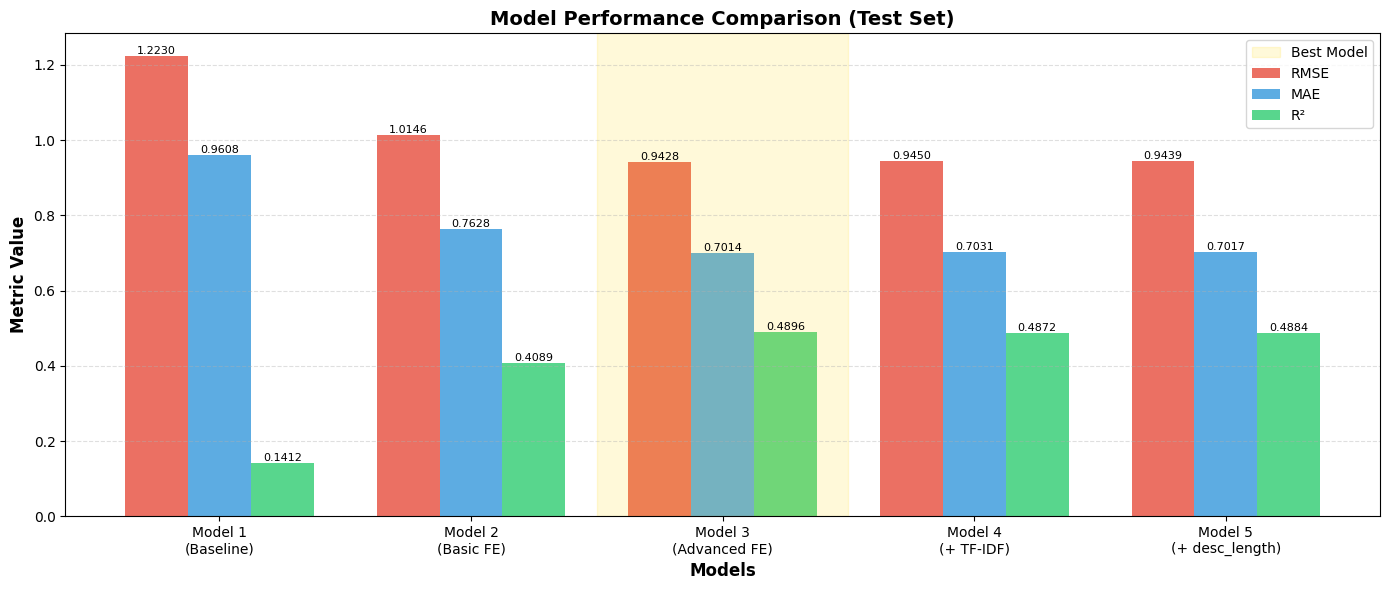

In [81]:
# Collect metrics from all models
models_comparison = {
    'Model 1\n(Baseline)': model1,
    'Model 2\n(Basic FE)': model2,
    'Model 3\n(Advanced FE)': model3,
    'Model 4\n(+ TF-IDF)': model4,
    'Model 5\n(+ desc_length)': model5
}

# Extract test metrics for each model
test_metrics = []
for model_name, model in models_comparison.items():
    y_pred_temp = model.predict(X_test if 'TF-IDF' in model_name else 
                                 (X_test_v3 if 'Advanced' in model_name else
                                  (X_test_v2 if 'Basic' in model_name else
                                   (X_test_v4 if 'desc_length' in model_name else X_test_v1))))
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mae = mean_absolute_error(y_test, y_pred_temp)
    r2 = r2_score(y_test, y_pred_temp)
    
    test_metrics.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

df_metrics = pd.DataFrame(test_metrics)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df_metrics))
width = 0.25

# Plot bars for each metric
bars1 = ax.bar(x - width, df_metrics['RMSE'], width, label='RMSE', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x, df_metrics['MAE'], width, label='MAE', color='#3498db', alpha=0.8)
bars3 = ax.bar(x + width, df_metrics['R²'], width, label='R²', color='#2ecc71', alpha=0.8)

# Highlight the best model (Model 3)
ax.axvspan(1.5, 2.5, alpha=0.15, color='gold', label='Best Model')

# Customize chart
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison (Test Set)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Model'], fontsize=10)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

As we can see the best model is Model 3

## 10. Finding Feature Importances


In [73]:
# Use the best model (Model 3) for feature importance analysis
best_model = model3

# Extract the RandomForest model (no pipeline, direct model)
rf_model = best_model.named_steps["model"]

# Get feature names from the training data used for Model 3
feature_names = X_train_v3.columns.tolist()

print(f"[INFO] Total number of features: {len(feature_names)}")
print(f"[INFO] RF importance count: {len(rf_model.feature_importances_)}")

# Create feature importance dataframe
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Display top 15 most important features
print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES (Model 3)")
print("="*60)
fi.head(15)

[INFO] Total number of features: 31
[INFO] RF importance count: 31

TOP 15 MOST IMPORTANT FEATURES (Model 3)


,feature,importance
30,director_score,0.419050
15,Horror,0.142090
0,runtime,0.104403
8,Documentary,0.102092
1,log_votes,0.086484
9,Drama,0.040113
2,Action,0.025303
22,Sci-Fi,0.024618
29,cast_score,0.015084
4,Animation,0.007118


## 11. Visualization of Results

### 11.1 Predicted vs. Actual Scatter Plot

We plot the Actual ratings (X-axis) against our Predicted ratings (Y-axis). 
* The **red dashed line** represents a perfect prediction.
* Points closer to this line are accurate.
* Points far from the line represent errors. 

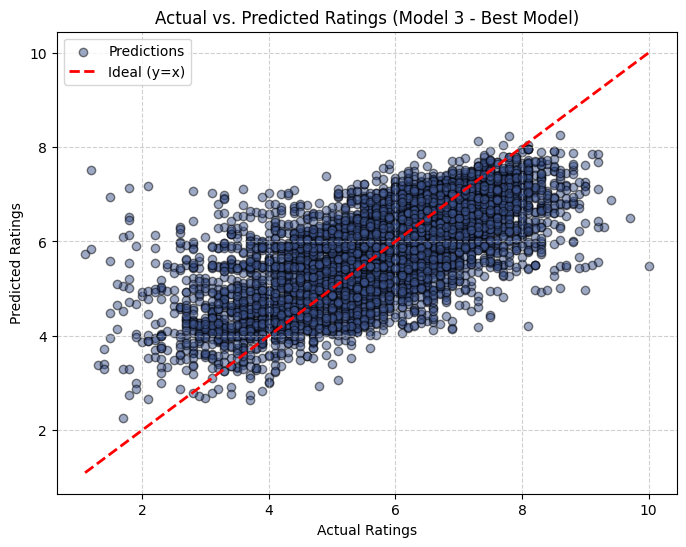

In [76]:
# Use the best model (Model 3) to get predictions on test set
y_pred = best_model.predict(X_test_v3)

plt.figure(figsize=(8, 6))

# Main scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, color='#3b528b', edgecolor='k', label='Predictions')

# Reference Line (Perfect Prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings (Model 3 - Best Model)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatter plot shows that the model generally predicts ratings in the right direction. Most points are close to the diagonal line, which means the predicted values are usually similar to the real values.

But the points spread out more, tells us the model is not perfect and sometimes makes bigger mistakes. This is normal because movie ratings depend on many subjective things, like personal taste or story quality, which are hard to capture with data.

### 10.2 Residual Plot

This plot checks for **bias** and **patterns in errors**. 
* We want to see a random cloud of points centered around the red line (0 error).
* If we see a pattern (like a funnel shape or curve), it suggests the model might be missing important information or relationships.
* Our Random Forest model shows a relatively random distribution around zero, indicating that it captures most of the underlying patterns in the data.

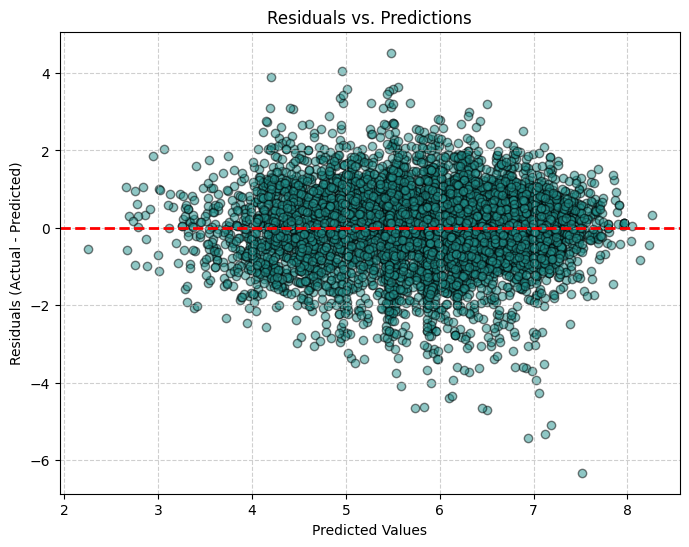

In [77]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#21918c', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predictions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the residual plot, the points are spread around zero without forming any strong systematic pattern. This is a good sign because it means:

* **No major systematic bias** - The model doesn't consistently over-predict or under-predict for specific ranges.
* **Random Forest captures non-linear relationships** - Unlike linear models, Random Forest can model complex patterns, and the relatively random residual distribution confirms this.
* **Acceptable variance** - Though residuals have some spread, it's expected given the subjective nature of movie ratings.

However, the residuals still have a considerable range, meaning some predictions are far from actual values. This is normal because movie ratings depend on many subjective factors (personal taste, cultural context, timing) that are inherently difficult to capture even with sophisticated features and ensemble methods like Random Forest.

### 10.3 Error Distribution

The histogram shows the spread of our errors.

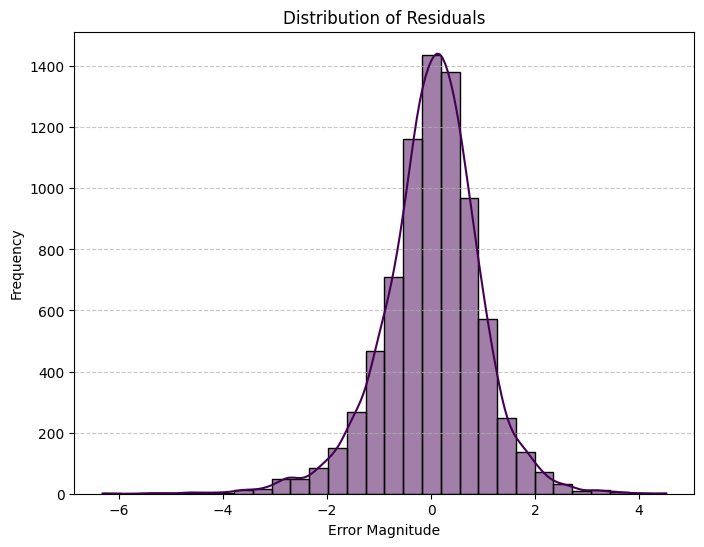

In [78]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='#440154', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The error distribution looks like a bell-shaped curve centered around zero. This means:

* The errors are mostly normal and balanced,
* The model doesn’t consistently guess too high or too low,
* Most predictions are close to the real rating.

There are a few errors that are larger than usual, but this is expected in real datasets, especially when dealing with human opinions like movie ratings.

### 10.4 Learning Curve Analysis

The Learning Curve helps us diagnose bias and variance by plotting the model's performance on the training set and the validation set.

* **Training Score (Red):** How well the model learns from the data it has seen.
* **Cross-Validation Score (Green):** How well the model generalizes to new, unseen data.

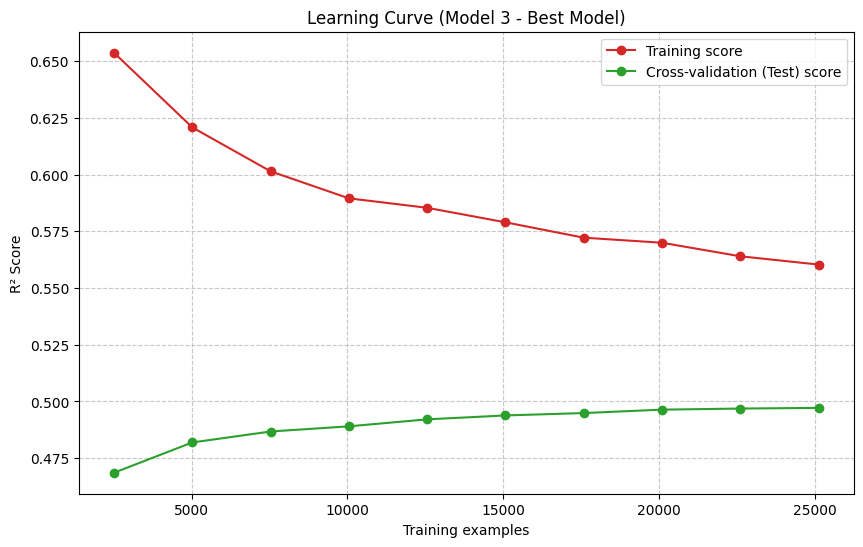

In [79]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#d62728", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2ca02c", label="Cross-validation (Test) score")
    
    plt.title("Learning Curve (Model 3 - Best Model)")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run the plot with Model 3 training data
plot_learning_curve(best_model, X_train_v3, y_train)

**Observation:**

The learning curve reveals critical insights about the model's behavior:

1.  **Consistent Gap:** There's a persistent gap of about 0.05-0.10 between training and validation scores throughout. This indicates the model has some variance but is primarily limited by bias - it's not complex enough to capture all patterns in the data.

2.  **Plateau Effect:** After about 15,000-20,000 samples, both curves flatten significantly. Adding more training data beyond this point provides minimal improvement, suggesting we've reached the model's learning capacity with the current feature set.

3.  **What This Means:**
   - **More data won't help much** - The curves have plateaued, indicating data sufficiency.
   - **Better features needed** - To improve performance, we'd need more informative features or a more complex model architecture rather than more examples.
   - **Acceptable performance** - Given the subjective nature of movie ratings, an R² of ~0.49 on unseen data is reasonable.